# Projet Data Analyst: Gestion de Crise Financière
## Détection Précoce des Entreprises en Risque de Défaut

Ce notebook présente une analyse complète, de l'exploration des données à la construction et à l'interprétation d'un modèle de régression pour évaluer la santé financière des entreprises.

### Étape 1 : Préparation de l'environnement et chargement des données

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.linear_model import LinearRegression, Ridge, Lasso # Les modèles de régression

### Étape 2 : Chargement et Préparation des données

In [3]:
# Charger le jeu de données
df = pd.read_csv('C:/Users/trava/Documents/Formation_data_analyst/Projet_fil_rouge/donnees_modifiee_liquidee_dai/fichier_nettoye_avec_scores.csv')

print(df.columns)

print(f"📊 Df : {df.shape[0]} données, {df.shape[1]} variables")
print("\n🔍 Aperçu des données :")
display(df.head())

print("\n📋 Informations générales :")
df.info()

Index(['entreprise_id', 'mois', 'annee', 'secteur', 'contrepartie_1',
       'contrepartie_2', 'contrepartie_3', 'interbank_lent',
       'interbank_borrowed', 'exposure_derivatives', 'exposure_sec',
       'repo_expo', 'guarantees_given', 'assets_total', 'liabilities_total',
       'equity', 'levier_ratio', 'provisions', 'net_income', 'debt_to_equity',
       'interest_coverage_ratio', 'cash_flow', 'free_cash_flow',
       'operating_cash_flow', 'current_ratio', 'quick_ratio', 'roa', 'roe',
       'net_margin', 'retard_publication', 'turnover_mgr', 'sentiment_media',
       'indice_sectoriel', 'sante_continu', 'sante_label'],
      dtype='object')
📊 Df : 40355 données, 35 variables

🔍 Aperçu des données :


,entreprise_id,mois,annee,secteur,contrepartie_1,contrepartie_2,contrepartie_3,interbank_lent,interbank_borrowed,exposure_derivatives,...,quick_ratio,roa,roe,net_margin,retard_publication,turnover_mgr,sentiment_media,indice_sectoriel,sante_continu,sante_label
0,0,1,1,banque,461,74,232,17.214436,20.427343,11.851299,...,0.985746,0.077071,0.187597,0.110133,1,0,-0.082456,99.705257,0.337565,en_difficulté
1,0,2,1,banque,461,74,232,17.329114,14.925713,11.735170,...,0.849917,0.054407,0.106343,0.056978,0,0,-0.138488,101.844974,0.357846,en_difficulté
2,0,3,1,banque,461,74,232,17.443283,17.481164,12.743398,...,0.936547,0.079477,0.216930,0.070174,1,0,0.131740,103.557709,0.437405,stable
3,0,4,1,banque,461,74,232,17.556435,14.134119,20.208590,...,1.003516,0.075653,0.190549,0.029891,0,0,-0.133312,105.219563,0.697679,stable
4,0,5,1,banque,461,74,232,17.668067,18.530073,18.242795,...,1.000818,0.059170,0.180977,0.156104,0,0,0.020598,106.955504,0.341220,en_difficulté



📋 Informations générales :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40355 entries, 0 to 40354
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   entreprise_id            40355 non-null  int64  
 1   mois                     40355 non-null  int64  
 2   annee                    40355 non-null  int64  
 3   secteur                  40355 non-null  object 
 4   contrepartie_1           40355 non-null  int64  
 5   contrepartie_2           40355 non-null  int64  
 6   contrepartie_3           40355 non-null  int64  
 7   interbank_lent           40355 non-null  float64
 8   interbank_borrowed       40355 non-null  float64
 9   exposure_derivatives     40355 non-null  float64
 10  exposure_sec             40355 non-null  float64
 11  repo_expo                40355 non-null  float64
 12  guarantees_given         40355 non-null  float64
 13  assets_total             40355 non-null  float64

In [4]:
df['net_margin'].fillna(df['net_margin'].median(), inplace=True)
df['net_margin_change'] = df.groupby('entreprise_id')['net_margin'].pct_change().fillna(0)

C:\Users\trava\AppData\Local\Temp\ipykernel_30220\3346062440.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['net_margin'].fillna(df['net_margin'].median(), inplace=True)


### Étape 3 : Analyse Exploratoire des Données (EDA)

#### 3.1. Analyse de la variable cible : 'sante_continu'

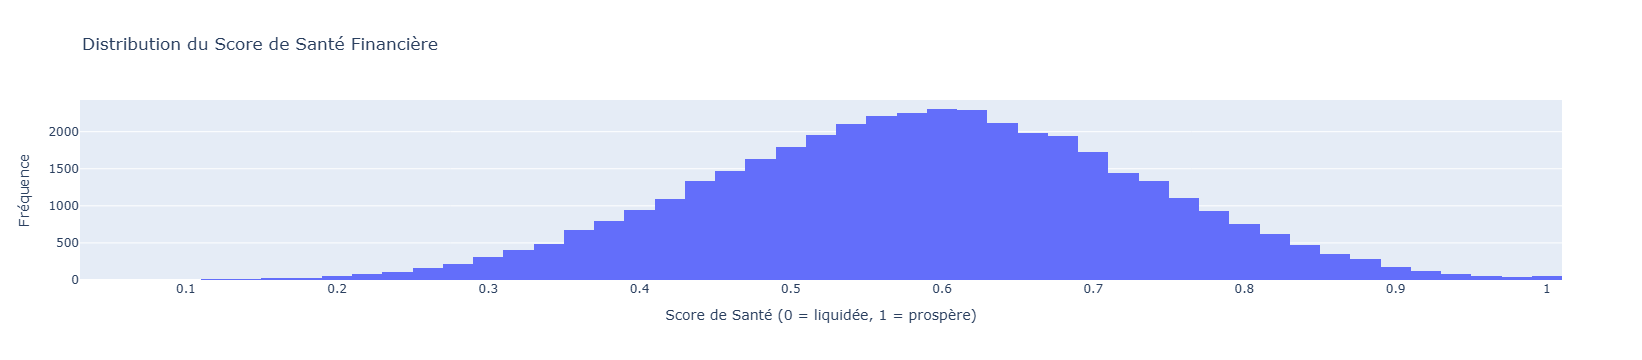

In [20]:
fig = px.histogram(df, x='sante_continu', nbins=50, title='Distribution du Score de Santé Financière')
fig.update_layout(xaxis_title="Score de Santé (0 = liquidée, 1 = prospère)", yaxis_title="Fréquence")
fig.show()

#### 3.2. Analyse des secteurs

secteur
banque         135
industrie      126
technologie    123
services       116
Name: count, dtype: int64


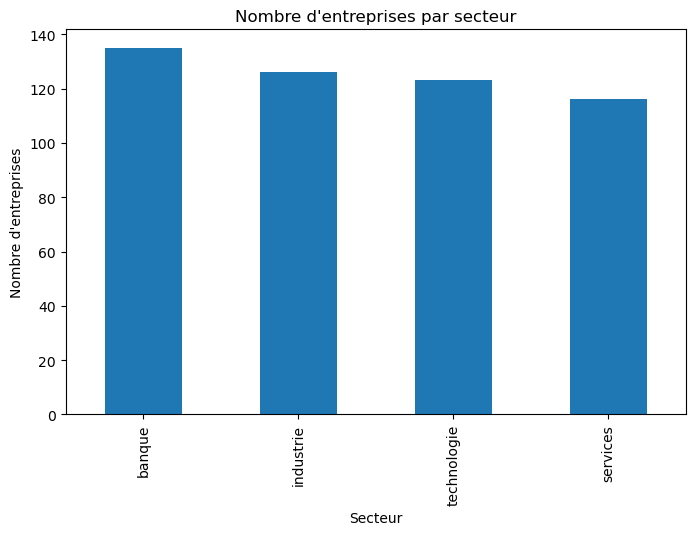

In [14]:
Nb_ent_par_secteur = df[['entreprise_id', 'secteur']].drop_duplicates()['secteur'].value_counts()
print(Nb_ent_par_secteur)
counts = df[['entreprise_id', 'secteur']].drop_duplicates()['secteur'].value_counts()

counts.plot(kind='bar', figsize=(8,5))
plt.title("Nombre d'entreprises par secteur")
plt.xlabel("Secteur")
plt.ylabel("Nombre d'entreprises")
plt.show()

#### 3.2. Analyse des états de santé

Répartition des types d'entreprises :
sante_label
stable           27843
solide            8030
en_difficulté     3793
prospère           652
liquidée            37
Name: count, dtype: int64


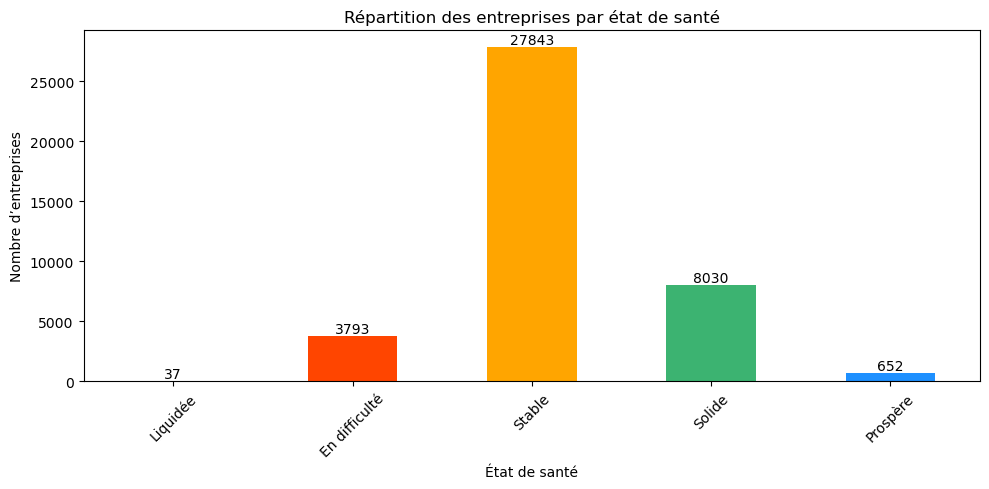

In [17]:
# 🌺 Exploration des types d'entreprises
print("Répartition des types d'entreprises :")
label_counts = df['sante_label'].value_counts()
print(label_counts)

# palette
palette = {
    "liquidée": "gray",       
    "en_difficulté": "orangered",  
    "stable": "orange",         
    "solide": "mediumseagreen",        
    "prospère": "dodgerblue"       
}

# mapping des labels pour affichage
rename_labels = {
    "en_difficulté": "En difficulté",
    "stable": "Stable",
    "solide": "Solide",
    "prospère": "Prospère",
    "liquidée": "Liquidée"
}
label_counts = label_counts.rename(index=rename_labels)

# ordre souhaité
ordre = ["Liquidée", "En difficulté", "Stable", "Solide", "Prospère"]

# réindexer dans l’ordre choisi
label_counts = label_counts.reindex(ordre)

# couleurs dans l’ordre
colors_bar = [palette[label.lower().replace(" ", "_")] for label in label_counts.index]

# affichage
plt.figure(figsize=(10, 5))
ax = label_counts.plot(kind='bar', color=colors_bar)

# Ajouter les valeurs au-dessus de chaque barre
for i, v in enumerate(label_counts):
    ax.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=10, fontweight='normal')

plt.title("Répartition des entreprises par état de santé")
plt.xlabel("État de santé")
plt.ylabel("Nombre d’entreprises")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


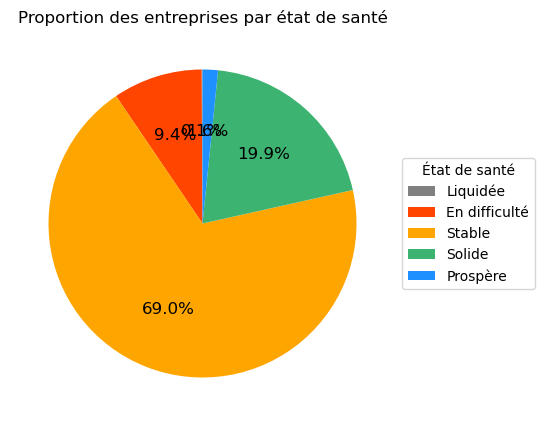

In [18]:
plt.figure(figsize=(10, 5))
plt.pie(
    label_counts.values,
    autopct='%1.1f%%',   # seulement les % dans le cercle
    colors=[palette[label.lower().replace(" ", "_")] for label in label_counts.index],
    startangle=90,
    textprops={'fontsize': 12}
)
plt.legend(
    labels=label_counts.index, 
    title="État de santé", 
    loc="center left", 
    bbox_to_anchor=(1, 0.5)  # légende à droite
)
plt.title("Proportion des entreprises par état de santé")
plt.show()

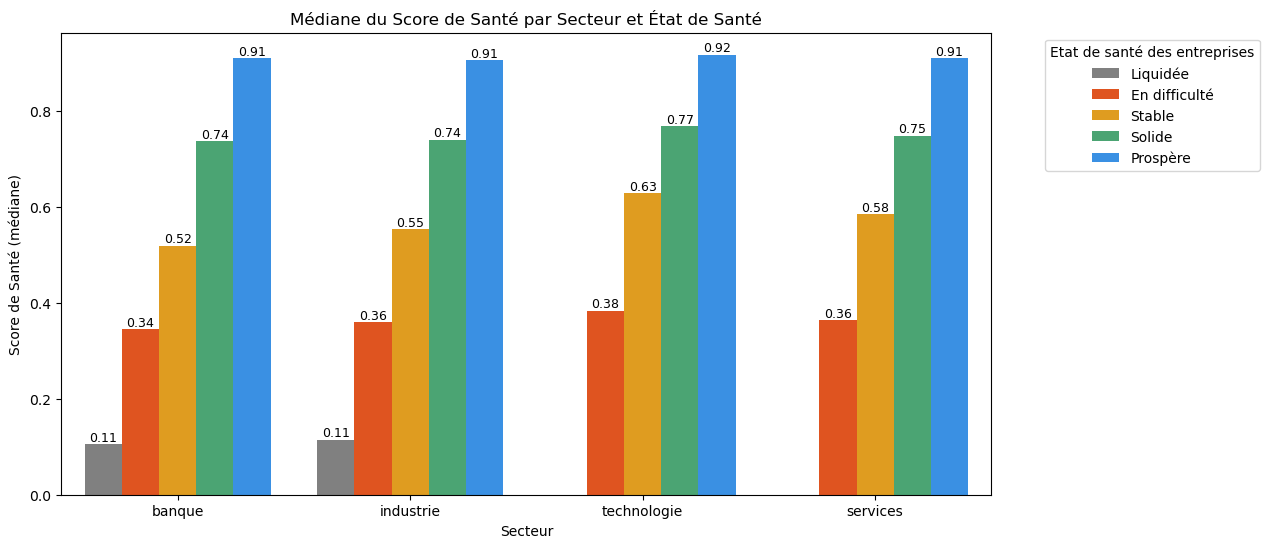

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,6))  # 👉 élargit l’image

palette = {
    "liquidée": "gray",       
    "en_difficulté": "orangered",  
    "stable": "orange",         
    "solide": "mediumseagreen",        
    "prospère": "dodgerblue"       
}

# Ordre correct (avec les clés brutes présentes dans df.sante_label)
order = ["liquidée", "en_difficulté", "stable", "solide", "prospère"]

# Mapping lisible (majuscules + accents)
rename_labels = {
    "liquidée": "Liquidée",
    "en_difficulté": "En difficulté",
    "stable": "Stable",
    "solide": "Solide",
    "prospère": "Prospère"
}

ax = sns.barplot(
    data=df.reset_index(),
    x="secteur",
    y="sante_continu",
    hue="sante_label",
    estimator=np.median,
    errorbar=None,
    palette=palette,
    hue_order=order  
)

plt.title("Médiane du Score de Santé par Secteur et État de Santé")
plt.ylabel("Score de Santé (médiane)")
plt.xlabel("Secteur")

# Renommer les légendes après coup
handles, labels = ax.get_legend_handles_labels()
new_labels = [rename_labels.get(lbl, lbl) for lbl in labels]
plt.legend(handles, new_labels, title="Etat de santé des entreprises", bbox_to_anchor=(1.05, 1), loc='upper left')

# ➕ Ajouter les valeurs au-dessus de chaque barre
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=9)

plt.show()


### Étape 4 : Analyse de Correlation entre les variables

#### 4.1. Corrélation des variables avec la santé financière

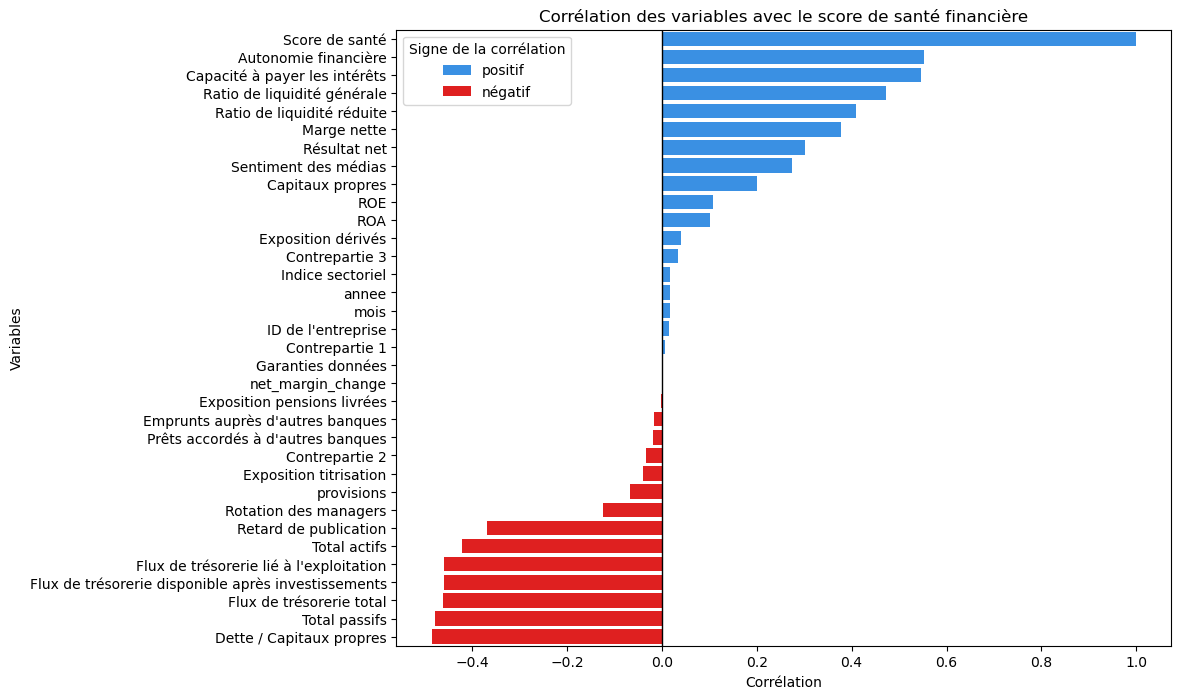

In [21]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
correlation_matrix = df[numeric_cols].corr()
target_correlations = correlation_matrix['sante_continu'].sort_values(ascending=False)

corr_df = pd.DataFrame({
    "variable": target_correlations.index,
    "correlation": target_correlations.values,
    "sign": target_correlations.apply(lambda x: "positif" if x >= 0 else "négatif")
})


rename_vars = {
    "sante_continu": "Score de santé",
    "entreprise_id": "ID de l'entreprise",
    "levier_ratio": "Autonomie financière", #D'après Chatgpt, ce n'est pas la même def que levier ratio
    "interest_coverage_ratio": "Capacité à payer les intérêts",
    "current_ratio": "Ratio de liquidité générale",
    "quick_ratio": "Ratio de liquidité réduite",
    "net_margin": "Marge nette",
    "net_income": "Résultat net",
    "sentiment_media": "Sentiment des médias",
    "equity": "Capitaux propres",
    "roe": "ROE",
    "roa": "ROA",
    "assets_total": "Total actifs",
    "liabilities_total": "Total passifs",
    "debt_to_equity": "Dette / Capitaux propres",
    "retard_publication": "Retard de publication",
    "turnover_mgr": "Rotation des managers",
    "exposure_derivatives": "Exposition dérivés",
    "contrepartie_1" : "Contrepartie 1",
    "contrepartie_2" : "Contrepartie 2",
    "contrepartie_3" : "Contrepartie 3",
    "guarantees_given" : "Garanties données",
    "indice_sectoriel": "Indice sectoriel",
    "cash_flow": "Flux de trésorerie total",
    "free_cash_flow": "Flux de trésorerie disponible après investissements",
    "operating_cash_flow": "Flux de trésorerie lié à l'exploitation",
    "interbank_lent": "Prêts accordés à d'autres banques",
    "interbank_borrowed": "Emprunts auprès d'autres banques",
    "repo_expo": "Exposition pensions livrées",
    "exposure_sec": "Exposition titrisation"
}

corr_df["variable"] = corr_df["variable"].replace(rename_vars)

plt.figure(figsize=(10, 8))
sns.barplot(
    data=corr_df,
    x="correlation",
    y="variable",
    hue="sign",
    dodge=False,   # pas de barres séparées
    palette={"positif": "dodgerblue", "négatif": "r"}
)

plt.title("Corrélation des variables avec le score de santé financière")
plt.xlabel("Corrélation")
plt.ylabel("Variables")

plt.axvline(0, color="black", linewidth=1)
plt.legend(title="Signe de la corrélation")
plt.show()


#### 4.2. Corrélation générale entre les variables (matrice de corrélation)

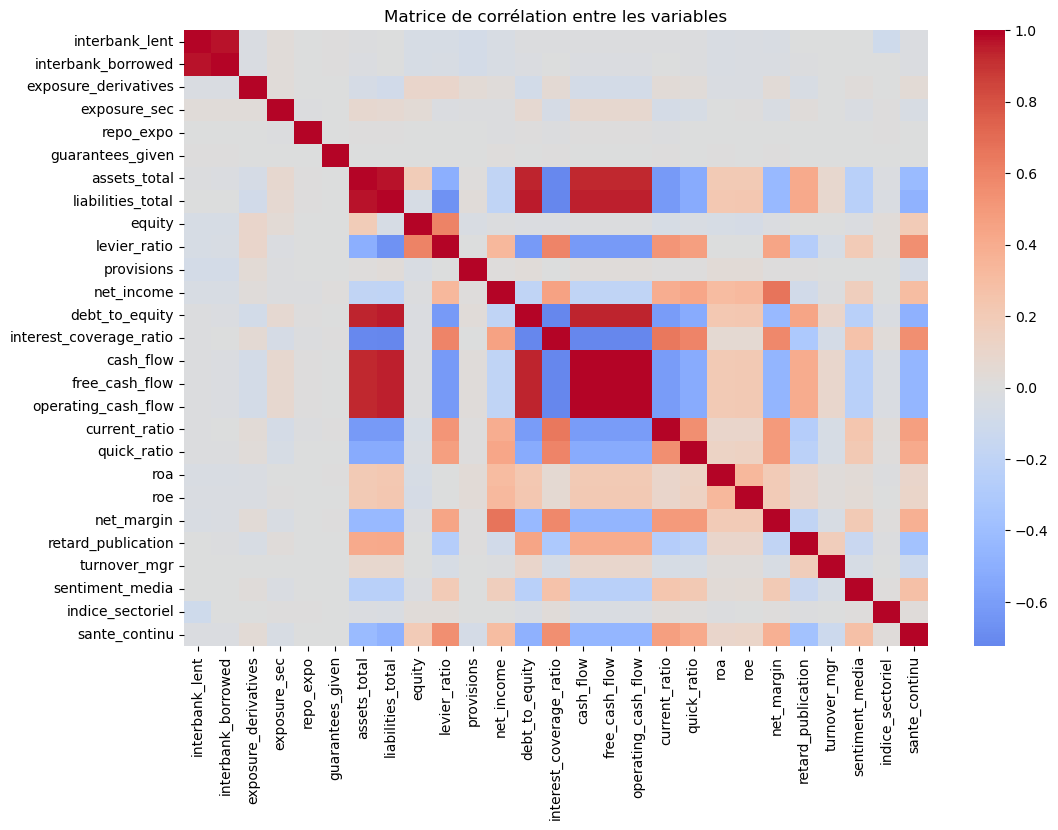

In [22]:
# Calcul de la matrice de corrélation

features = ['interbank_lent','interbank_borrowed', 'exposure_derivatives', 'exposure_sec','repo_expo', 
            'guarantees_given', 'assets_total', 'liabilities_total','equity', 'levier_ratio', 'provisions', 
            'net_income', 'debt_to_equity','interest_coverage_ratio', 'cash_flow', 'free_cash_flow',
            'operating_cash_flow', 'current_ratio', 'quick_ratio', 'roa', 'roe',
            'net_margin', 'retard_publication', 'turnover_mgr', 'sentiment_media',
            'indice_sectoriel', 'sante_continu']

corr = df[features].corr(numeric_only=True)

# Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Matrice de corrélation entre les variables")
plt.show()

### Étape 5 : Ingénierie des Caractéristiques et Modélisation

#### 5.1 Encodage & features

In [8]:
# Encodage des variables catégorielles
if 'secteur' in df.columns:
    df = pd.get_dummies(df, columns=['secteur'], drop_first=False)

# Sélection des features
features = ['interbank_lent','interbank_borrowed', 'exposure_derivatives', 'exposure_sec','repo_expo', 
            'guarantees_given', 'assets_total', 'liabilities_total','equity', 'levier_ratio', 'provisions', 
            'net_income', 'debt_to_equity','interest_coverage_ratio', 'cash_flow', 'free_cash_flow',
            'operating_cash_flow', 'current_ratio', 'quick_ratio', 'roa', 'roe',
            'net_margin', 'retard_publication', 'turnover_mgr', 'sentiment_media',
            'indice_sectoriel', 'net_margin_change', 
            'secteur_industrie', 'secteur_services', 'secteur_technologie']


# Définition de X/Y et split
X = df[features]
y = df['sante_continu']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### 5.2 Modèles testés

##### 5.2.1. Modèles simples

In [40]:
def evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = np.mean(np.abs(y_test - y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, mae, r2

# Initialisation et entraînement des modèles
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(random_state=42, objective="reg:squarederror"),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}

# Dictionnaire pour stocker les résultats
results = {}

for name, model in models.items():
    rmse, mae, r2 = evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test)
    results[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Affichage des résultats dans un tableau
results_df = pd.DataFrame(results).T.sort_values(by='R2', ascending=False)
print("\n--- Comparaison des modèles ---\n")
print(results_df)

# Choix du meilleur modèle basé sur le R2
best_model_name = results_df.index[0]
best_model = models[best_model_name]
print(f"\n🏆 Le meilleur modèle basé sur le R2 est le : {best_model_name}")


--- Comparaison des modèles ---

                       RMSE       MAE        R2
Gradient Boosting  0.101388  0.081154  0.468247
Random Forest      0.102843  0.082476  0.452874
Linear Regression  0.103302  0.082607  0.447989
XGBoost            0.105369  0.084273  0.425669

🏆 Le meilleur modèle basé sur le R2 est le : Gradient Boosting


##### 5.2.2. Hyperparamétrage des modèles

##### Modèle Ridge (Recherche d'alpha)

In [46]:
ridge = RidgeCV(alphas=np.logspace(-3, 2, 50), cv=5)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge   = r2_score(y_test, y_pred_ridge)
print(f" RMSE: {rmse_ridge:.4f} et R²: {r2_ridge:.4f}")

 RMSE: 0.1033 et R²: 0.4480


##### Modèle Random Forest (RandomizedSearchCV)

In [47]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=42, n_estimators=400, n_jobs=-1)

rf_dist = {
    "max_depth": [None, 5, 10, 15],
    "max_features": ["sqrt", "log2"],
    "min_samples_leaf": [1, 2, 4],
    "min_samples_split": [2, 5, 10],
}
rf_search = RandomizedSearchCV(rf, rf_dist, n_iter=40, cv=3, scoring="r2", n_jobs=-1, random_state=42, verbose=1)

rf_search.fit(X_train_scaled, y_train)

best_rf = rf_search.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf   = r2_score(y_test, y_pred_rf)

print("Best params:", rf_search.best_params_)
print(f"RandomForest (optimisé). RMSE: {rmse_rf:.4f} et R²: {r2_rf:.4f}")

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best params: {'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 15}
RandomForest (optimisé). RMSE: 0.1024 et R²: 0.4575


##### Modèle XGBoost

###### Avec GridSearchCV

In [13]:
xgb = XGBRegressor(
    random_state=42, 
    objective="reg:squarederror",
    tree_method="hist"
)

# Grille d’hyperparamètres
param_grid_xgb = {
    "n_estimators": [200, 600],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0]
}

grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=3, scoring="r2", n_jobs=-1)
grid_xgb.fit(X_train_scaled, y_train)

# Meilleur modèle
best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_scaled)
# Scores
rmse_xgb_gscv = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb_gscv = r2_score(y_test, y_pred_xgb)

print("XGBoost → Best params:", grid_xgb.best_params_)
print(f"RMSE: {rmse_xgb_gscv:.6f}, R²: {r2_xgb_gscv:.6f}")

XGBoost → Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
RMSE: 0.101285, R²: 0.469333


###### Avec RandomizedSearchCV

In [12]:
from sklearn.model_selection import RandomizedSearchCV

# 1) Modèle de base (simple, stable)
xgb_base = XGBRegressor(
    random_state=42,
    objective="reg:squarederror",
    n_estimators=800,    
    tree_method="hist"   
)

# 2) Espace de recherche (discret = simple)
xgb_dist = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.85, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0],
}

# 3) RandomizedSearchCV (simple & rapide)
xgb_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=xgb_dist,
    n_iter=30,         
    cv=3,              
    scoring="r2",
    n_jobs=-1,
    random_state=42,
    verbose=0
)

# 4) Fit de la recherche (séparé de ta boucle)
xgb_search.fit(X_train_scaled, y_train)

# 5) Évaluation finale sur le test
best_xgb = xgb_search.best_estimator_
y_pred = best_xgb.predict(X_test_scaled)
rmserf_rdscv = float(np.sqrt(mean_squared_error(y_test, y_pred)))
r2_rf_rdscv = float(r2_score(y_test, y_pred))

print("XGB — meilleurs hyperparamètres:", xgb_search.best_params_)
print(f"XGB (random search) — R²: {r2_rf_rdscv:.4f} | RMSE: {rmserf_rdscv:.4f}")


XGB — meilleurs hyperparamètres: {'subsample': 0.7, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
XGB (random search) — R²: 0.4691 | RMSE: 0.1013


##### Modèle Gradient Boosting

###### Avec GridSearchCV

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(random_state=42)

param_grid_gb = {
    "n_estimators": [200, 600],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [2, 3, 5],
    "subsample": [0.8, 1.0],
}

grid_gb = GridSearchCV(
    estimator=gb,
    param_grid=param_grid_gb,
    cv=3,                 
    scoring="r2",
    n_jobs=-1,
    verbose=0
)

grid_gb.fit(X_train_scaled, y_train)

best_gb = grid_gb.best_estimator_
y_pred_gb = best_gb.predict(X_test_scaled)
rmse_gb_gscv = float(np.sqrt(mean_squared_error(y_test, y_pred_gb)))
r2_gb_gscv = float(r2_score(y_test, y_pred_gb))

print("Gradient Boosting → Best params:", grid_gb.best_params_)
print(f"Gradient Boosting — R²: {r2_gb_gscv:.6f} | RMSE: {rmse_gb_gscv:.6f}")

###### Avec RandomizedSearchCV

In [9]:
from sklearn.model_selection import RandomizedSearchCV

gb = GradientBoostingRegressor(random_state=42)

param_dist_gb = {
    "n_estimators": [200, 400, 600, 800],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [2, 3, 4, 5],
    "subsample": [0.6, 0.8, 1.0],
}

# 3) RandomizedSearchCV (échantillon aléatoire)
rand_gb = RandomizedSearchCV(
    estimator=gb,
    param_distributions=param_dist_gb,
    n_iter=30,          
    cv=3,
    scoring="r2",
    n_jobs=-1,
    random_state=42,
    verbose=0
)

# 4) Fit
rand_gb.fit(X_train_scaled, y_train)

best_gb = rand_gb.best_estimator_
y_pred_gb = best_gb.predict(X_test_scaled)

# 5) Scores
rmse_gb_rdscv = float(np.sqrt(mean_squared_error(y_test, y_pred_gb)))
r2_gb_rdscv   = float(r2_score(y_test, y_pred_gb))

print("Gradient Boosting (random) → Best params:", rand_gb.best_params_)
print(f"Gradient Boosting (random) — R²: {r2_gb_rdscv:.6f} | RMSE: {rmse_gb_rdscv:.6f}")

Gradient Boosting (random) → Best params: {'subsample': 0.6, 'n_estimators': 800, 'max_depth': 5, 'learning_rate': 0.01}
Gradient Boosting (random) — R²: 0.4688 | RMSE: 0.1013


#### 5.3. Comparaison des performances

#### 5.4. Analyse du modèle retenu

##### 5.4.1. Analyse des résidus

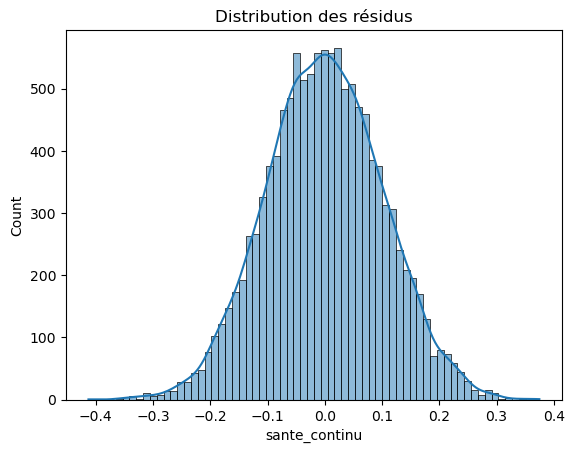

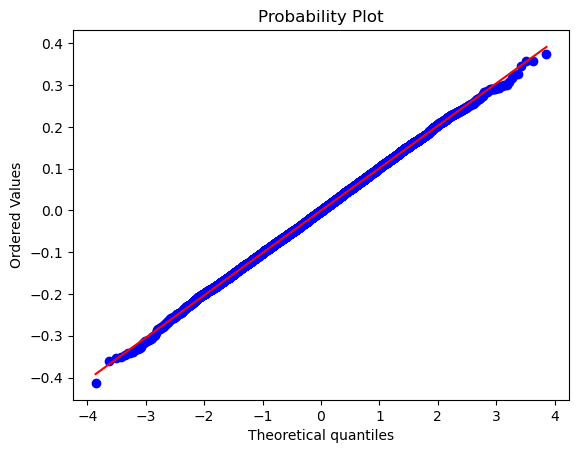

In [57]:
import scipy.stats as stats

resid_gbr_model = y_test - y_pred_gbr

sns.histplot(resid_gbr_model, kde=True)
plt.title("Distribution des résidus")
plt.show()

stats.probplot(resid_gbr_model, dist="norm", plot=plt)
plt.show()


##### 5.4.2. Importance globale des variables (permutation importance / feature importance)

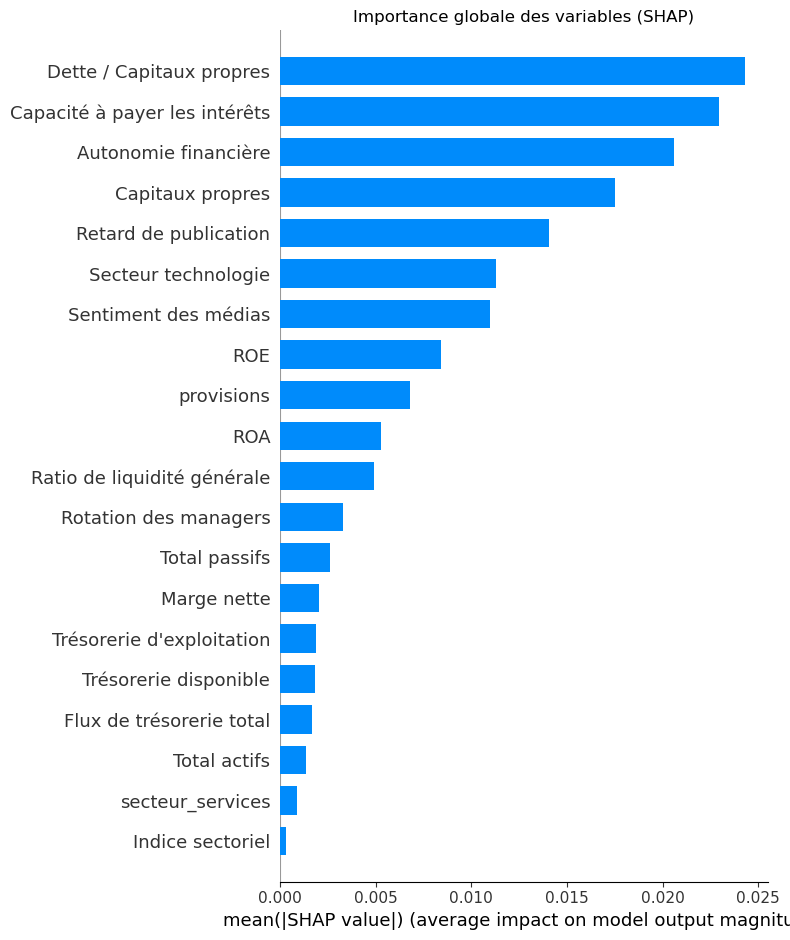

In [32]:

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled  = pd.DataFrame(X_test_scaled,  columns=X_test.columns,  index=X_test.index)

explainer = shap.TreeExplainer(gbr_model)
shap_values = explainer.shap_values(X_test_scaled)

# --- Dictionnaire de renommage (FR lisible) ---
rename_vars = {
    "sante_continu": "Score de santé",
    "entreprise_id": "ID de l'entreprise",
    "levier_ratio": "Autonomie financière",  # Equity/Assets
    "interest_coverage_ratio": "Capacité à payer les intérêts",
    "current_ratio": "Ratio de liquidité générale",
    "quick_ratio": "Ratio de liquidité réduite",
    "net_margin": "Marge nette",
    "net_income": "Résultat net",
    "sentiment_media": "Sentiment des médias",
    "equity": "Capitaux propres",
    "roe": "ROE",
    "roa": "ROA",
    "assets_total": "Total actifs",
    "liabilities_total": "Total passifs",
    "debt_to_equity": "Dette / Capitaux propres",
    "retard_publication": "Retard de publication",
    "turnover_mgr": "Rotation des managers",
    "exposure_derivatives": "Exposition dérivés",
    "contrepartie_1": "Contrepartie 1",
    "contrepartie_2": "Contrepartie 2",
    "contrepartie_3": "Contrepartie 3",
    "guarantees_given": "Garanties données",
    "indice_sectoriel": "Indice sectoriel",
    "cash_flow": "Flux de trésorerie total",
    "free_cash_flow": "Trésorerie disponible",
    "operating_cash_flow": "Trésorerie d'exploitation",
    "interbank_lent": "Prêts interbancaires (accordés)",
    "interbank_borrowed": "Emprunts interbancaires (reçus)",
    "repo_expo": "Exposition pensions livrées",
    "exposure_sec": "Exposition titrisation",
    "secteur_technologie": "Secteur technologie"
}

# --- Construire la table X avec colonnes renommées ---
def make_X_named(X):
    # Cas 1 : déjà un DataFrame -> on renomme les colonnes existantes
    if hasattr(X, "columns"):
        X_named = X.copy()
        X_named.rename(columns=lambda c: rename_vars.get(c, c), inplace=True)
        return X_named
    # Cas 2 : ndarray -> on récupère les noms de features depuis le modèle
    if hasattr(gbr_model, "feature_names_in_"):
        orig_cols = list(gbr_model.feature_names_in_)
    else:
        raise ValueError("Impossible d'inférer les noms des variables (ndarray et modèle sans feature_names_in_). "
                         "Passe X_test_scaled en DataFrame avec des colonnes.")
    new_cols = [rename_vars.get(c, c) for c in orig_cols]
    return pd.DataFrame(X, columns=new_cols)

X_named = make_X_named(X_test_scaled)


# --- 1) Importance globale (barres : moyenne de |SHAP|) ---
plt.figure()
shap.summary_plot(shap_values, X_named, plot_type="bar", show=False)
plt.gca().set_title("Importance globale des variables (SHAP)")
plt.tight_layout()
plt.show()

##### 5.4.3. SHAP : summary plot + explication des top features

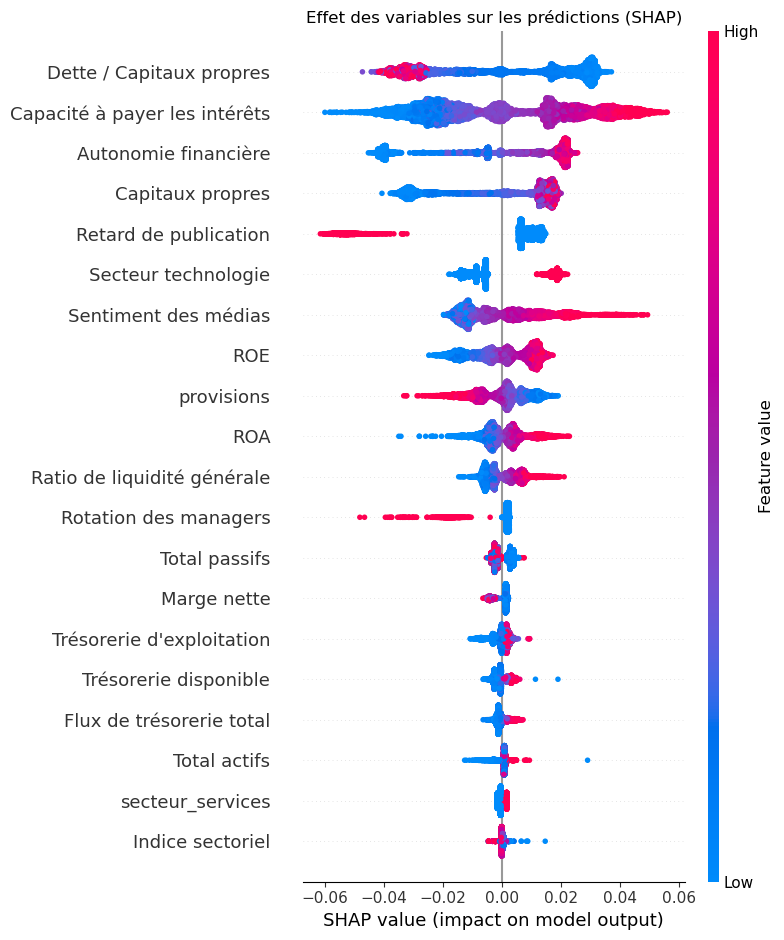

In [31]:
plt.figure()
shap.summary_plot(shap_values, X_named, show=False)  # nuage
plt.gca().set_title("Effet des variables sur les prédictions (SHAP)")
plt.tight_layout()
plt.show()

#### 5.5. Sanity check & biais

##### 5.5.1. Stabilité des résultats (k-fold CV)

In [13]:
from sklearn.model_selection import cross_val_score

gb_model = GradientBoostingRegressor(random_state=42)

# Cross-validation à 5 folds avec R² comme métrique
scores = cross_val_score(gb_model, X, y, cv=5, scoring='r2')

print("Scores par fold :", scores)
print("Moyenne R² :", np.mean(scores))
print("Écart-type R² :", np.std(scores))

Scores par fold : [0.48827093 0.47821408 0.43442503 0.45783571 0.51670365]
Moyenne R² : 0.47508988051079487
Écart-type R² : 0.027808425774767408


##### 5.2.2. Robustesse aux outliers

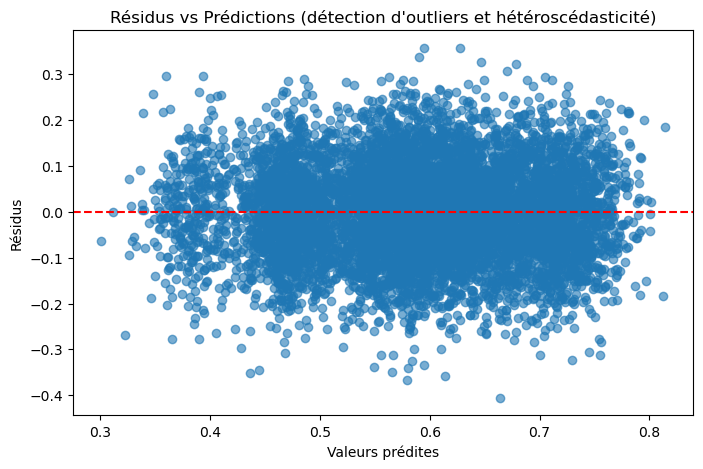

Nombre d'outliers détectés : 23
Indices d'outliers : [ 566  640  848 1094 1152]


In [29]:
import statsmodels.api as sm
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train_scaled, y_train)

# 1. Résidus vs prédictions
y_pred = gb_model.predict(X_test_scaled)
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Résidus vs Prédictions (détection d'outliers et hétéroscédasticité)")
plt.show()

# Détection des outliers par résidus > 3 * écart-type
y_pred = gb_model.predict(X_test_scaled)
residuals = y_test - y_pred

std_res = np.std(residuals)
outliers_idx = np.where(abs(residuals) > 3 * std_res)[0]

print(f"Nombre d'outliers détectés : {len(outliers_idx)}")
print("Indices d'outliers :", outliers_idx[:5]) 

##### 5.2.3. Comparaison baseline vs modèle

In [25]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error


dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train_scaled, y_train)

# Prédictions
y_dummy_pred = dummy.predict(X_test_scaled)

# Évaluation
r2_dummy = r2_score(y_test, y_dummy_pred)
rmse_dummy = mean_squared_error(y_test, y_dummy_pred, squared=False)
mape_dummy = mean_absolute_percentage_error(y_test, y_dummy_pred)

print("DummyRegressor (baseline)")
print(f"R²   : {r2_dummy:.3f}")
print(f"RMSE : {rmse_dummy:.3f}")
print(f"MAPE : {mape_dummy:.3f}")

DummyRegressor (baseline)
R²   : -0.000
RMSE : 0.139
MAPE : 0.221


C:\Users\trava\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


##### 5.2.4. Test de permutation (y mélangé)

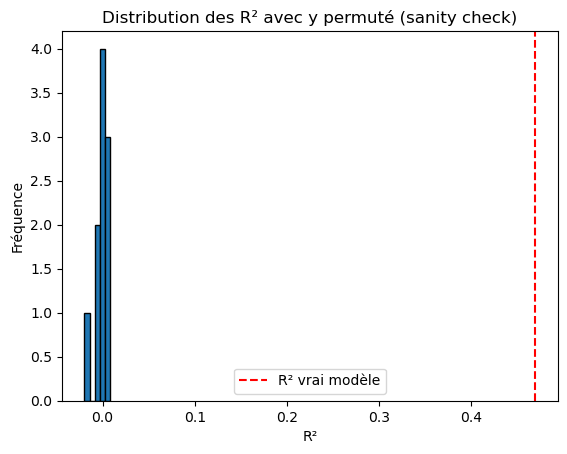

Moyenne des R² permutés : -0.0008542061952970581


In [31]:
scores_perm = []
for i in range(10):
    y_shuffled = np.random.permutation(y_train)
    gb_perm = GradientBoostingRegressor(random_state=42)
    gb_perm.fit(X_train_scaled, y_shuffled)
    y_pred_perm = gb_perm.predict(X_test_scaled)
    scores_perm.append(r2_score(y_test, y_pred_perm))

plt.hist(scores_perm, bins=5, edgecolor="black")
plt.axvline(0.47, color="red", linestyle="--", label="R² vrai modèle")
plt.title("Distribution des R² avec y permuté (sanity check)")
plt.xlabel("R²")
plt.ylabel("Fréquence")
plt.legend()
plt.show()

print("Moyenne des R² permutés :", np.mean(scores_perm))